In [1]:
import pandas as pd
import torch
from tailnflows.experiments.utils import load_experiment_data

torch.set_default_dtype(torch.float64)
torch.manual_seed(1000)

In [6]:
experiment_data, models, failed = load_experiment_data(
    'fret_remote_5', 
    # filter=lambda exp: exp['dim'] == 10,
    # load_models=True
)

In [7]:
assert len(failed) == 0, 'some models failed to load!'

In [5]:
# filter down to wanted data
target = 'financial_returns'
target_kwargs = {'top_n_symbols': 300}
experiment_data = experiment_data[experiment_data['target'] == target]
experiment_data = experiment_data[experiment_data['target_kwargs'] == target_kwargs]

In [8]:
import tqdm
from tailnflows.data import data_sources
import numpy as np
import warnings
warnings.filterwarnings("ignore")

metric_df = {
    'ix': [], 
    'test_ll': [], 
}

loop = tqdm.tqdm(experiment_data.index)
for ix in loop:
    row = experiment_data.loc[ix]
    metric_df['ix'].append(ix)
    p = row['disk_path']
    tdata = np.load(f'{p}/training_data.npy', allow_pickle=True).item()
    metric_df['test_ll'].append(float(tdata['test_loss']))

100%|██████████| 405/405 [00:00<00:00, 2525.59it/s]


### Produce tables

In [13]:
metric_df = pd.DataFrame(metric_df).set_index('ix')
metric_experiment_data = experiment_data.join(metric_df)
metric_experiment_data = metric_experiment_data.join(metric_experiment_data['target_kwargs'].apply(pd.Series))

In [15]:
def model_verbose(row):
    name = f'{row["model"]}_bb_{row["model_kwargs"]["tail_bound"]}'
    if row["model_kwargs"].get("rotation", False):
        name += '_rot'
    return name
metric_experiment_data['model'] =  metric_experiment_data.apply(model_verbose, axis=1)

In [16]:
mean_lls = metric_experiment_data.groupby(['top_n_symbols', 'model'])[['test_ll']].agg(['mean', 'sem'])

In [17]:
mean_lls

test_ll          
                                             mean       sem
top_n_symbols model                                        
10            EXFLOW_bb_2.5_rot         14.375263  0.024606
              RQS_flow_bb_2.5           15.161509  0.068409
              TTF_bb_2.5_rot            14.733354  0.054312
              TTF_marginal_bb_2.5       14.621436  0.047535
              TTF_marginal_bb_2.5_rot   14.625432  0.048016
              gTAF_bb_2.5               14.504440  0.048620
              gTAF_bb_5.0               14.417793  0.061025
              nflow_ADVI_bb_2.5         16.345831  0.133834
50            EXFLOW_bb_2.5             65.303426       NaN
              EXFLOW_bb_2.5_rot         65.328367  0.232417
              RQS_flow_bb_2.5           70.993342  0.444414
              TTF_bb_2.5_rot            68.866164  0.261754
              TTF_marginal_bb_2.5       66.853630  0.220537
              TTF_marginal_bb_2.5_rot   65.550290  0.231970
              gTAF_bb_2.5               65.600032  0.271979
              gTAF_bb_5.0               65.872968  0.280061
              nflow_ADVI_bb_2.5         79.862228  0.577914
100           EXFLOW_bb_2.5_rot        134.248328  0.421514
              RQS_flow_bb_2.5          154.657645  1.051241
              TTF_bb_2.5_rot           145.527824  0.626271
              TTF_marginal_bb_2.5      139.270353  0.574252
              TTF_marginal_bb_2.5_rot  136.871645  0.630720
              gTAF_bb_2.5              136.282398  0.514812
              gTAF_bb_5.0              137.540162  0.478221
              nflow_ADVI_bb_2.5        195.853248  4.064923
200           EXFLOW_bb_2.5_rot        267.988035  1.531201
              RQS_flow_bb_2.5          316.168638  1.910046
              TTF_bb_2.5_rot           292.582179  1.518239
              TTF_marginal_bb_2.5      279.398139  1.436208
              TTF_marginal_bb_2.5_rot  273.859864  1.110050
              gTAF_bb_2.5              276.182150  1.058984
              gTAF_bb_5.0              280.947298  1.044088
              nflow_ADVI_bb_2.5        408.986334  9.765428
300           EXFLOW_bb_2.5_rot        402.940933  1.536027
              RQS_flow_bb_2.5          473.283721  3.081740
              TTF_bb_2.5_rot           442.940184  2.618272
              TTF_marginal_bb_2.5      419.155167  2.139464
              TTF_marginal_bb_2.5_rot  412.226451  1.571433
              gTAF_bb_2.5              414.405845  1.586293
              gTAF_bb_5.0              426.351740  1.752058
              nflow_ADVI_bb_2.5        593.665376  9.355612

### Produce plots

In [ ]:
print(metric_experiment_data['model'].unique())
model_map = {
    'EXFLOW_bb_2.5_rot': 'EXT', 
    'TTF_marginal_bb_2.5_rot': 'TTF_m', 
    'gTAF_bb_2.5': 'gTAF', 
    'TTF_bb_2.5_rot': 'TTF',
    'RQS_flow_bb_2.5': 'RQS',
}

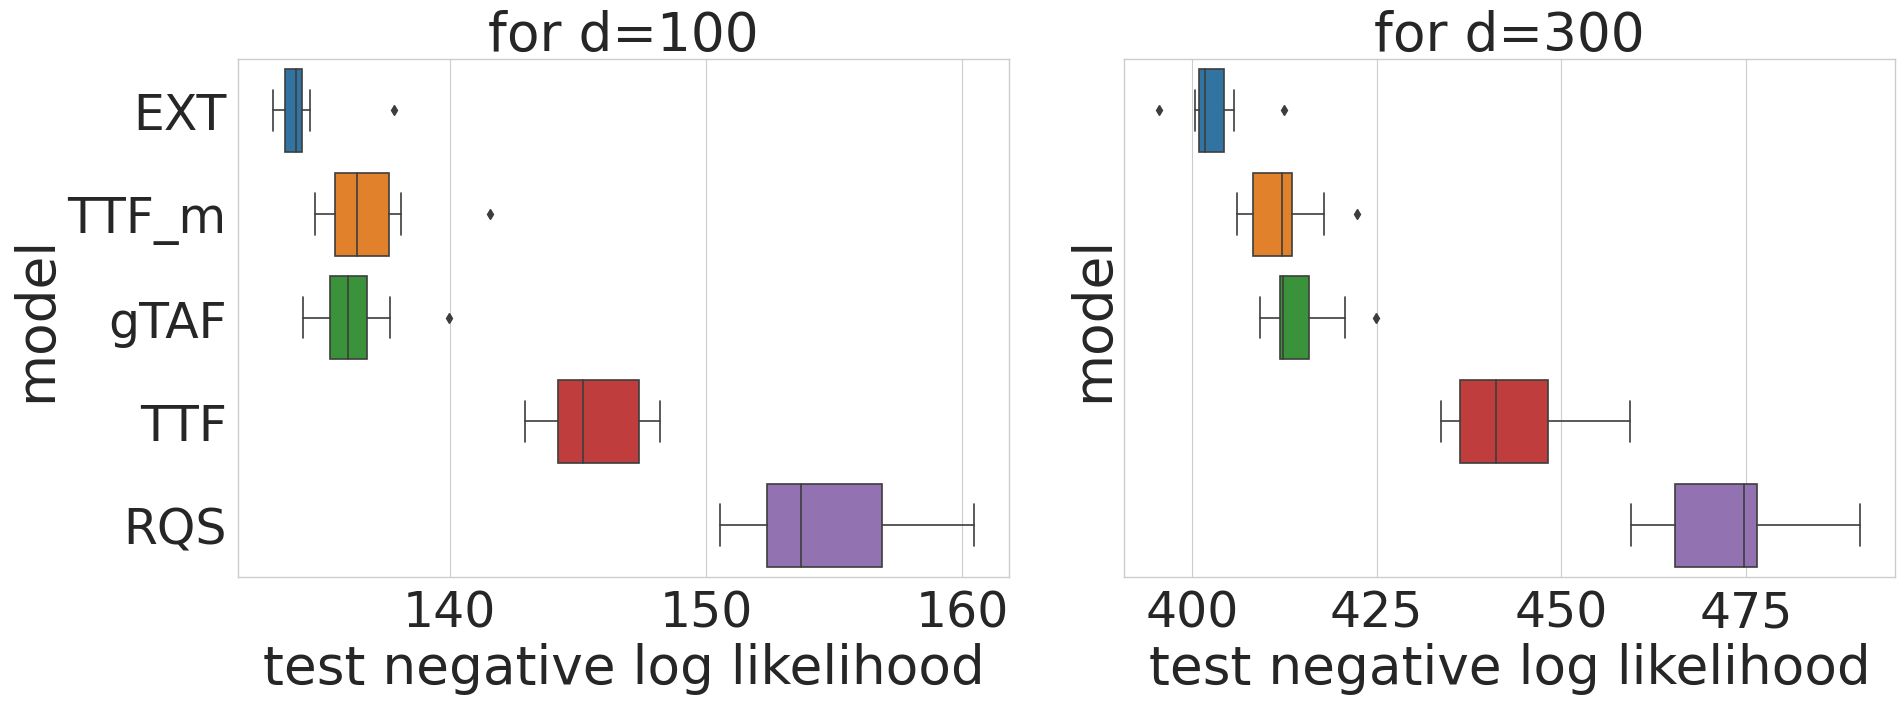

In [22]:
import matplotlib.pyplot as plt
import seaborn as sns

target_d = 300

fig, axarr = plt.subplots(1, 2, figsize=(20, 8), sharey=True, tight_layout=True)

sns.set_style("whitegrid")
sns.set_context("paper", font_scale=4.)

for ix, target_d in [(0, 100), (1, 300)]:
    wanted_data = metric_experiment_data[metric_experiment_data['top_n_symbols'] == target_d]
    wanted_data['model'] = wanted_data['model'].apply(lambda m: model_map.get(m, m))
    wanted_data = wanted_data[wanted_data['model'].isin(model_map.values())]

    sns.boxplot(
        data=wanted_data,
        x='test_ll', 
        y='model',
        order=model_map.values(),
        orient='h',
        ax=axarr[ix]
    )
    axarr[ix].set_title(f'for d={target_d}')
    axarr[ix].set_xlabel('test negative log likelihood')

fig.savefig(f"../../figs/llplot_combo.eps")
plt.tight_layout()
plt.show()